In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\elecproduction.csv", parse_dates=['DATE'])
df.columns = ['Date', 'Electricity']
df = df.sort_values('Date').set_index('Date').asfreq('MS')
df = df.dropna()
df.head()

,Electricity
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


<Axes: xlabel='Date'>

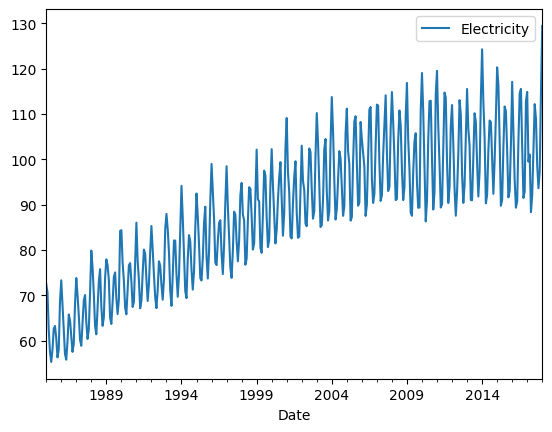

In [3]:
df.plot()

In [4]:
result = adfuller(df)
print(f'ADF Statistic: {result[0]:.5f}')
print(f'p-value: {result[1]:.5f}')

if result[1] > 0.05:
    print("Data tidak stasioner (p > 0.05), perlu transformasi atau differencing.\n")
else:
    print("Data stasioner (p < 0.05), asumsi terpenuhi.\n")

ADF Statistic: -2.25699
p-value: 0.18621
Data tidak stasioner (p > 0.05), perlu transformasi atau differencing.



In [11]:
dw_stat = durbin_watson(df)[0]
print(f'Durbin-Watson Statistic: {dw_stat:.5f}')

if 1.5 < dw_stat < 2.5:
    print("Tidak ada autokorelasi yang signifikan, asumsi terpenuhi.\n")
else:
    print("Terdapat autokorelasi, pertimbangkan model ARIMA atau lag variables.\n")

Durbin-Watson Statistic: 0.00738
Terdapat autokorelasi, pertimbangkan model ARIMA atau lag variables.



In [12]:
lb_test = acorr_ljungbox(df, lags=[10], return_df=True)
print(lb_test)

if lb_test["lb_pvalue"].values[0] > 0.05:
    print("Residual bersifat acak (p > 0.05), model sudah baik.\n")
else:
    print("Residual tidak acak (p < 0.05), coba model ARIMA atau tambahkan lag.\n")

        lb_stat  lb_pvalue
10  1934.574742        0.0
Residual tidak acak (p < 0.05), coba model ARIMA atau tambahkan lag.



In [13]:
arch_test = het_arch(df)
print(f'ARCH Test: p-value = {arch_test[1]:.5f}')

if arch_test[1] > 0.05:
    print("Tidak ada heteroskedastisitas yang signifikan, asumsi terpenuhi.\n")
else:
    print("Terdapat heteroskedastisitas, pertimbangkan model GARCH.\n")

ARCH Test: p-value = 0.00000
Terdapat heteroskedastisitas, pertimbangkan model GARCH.



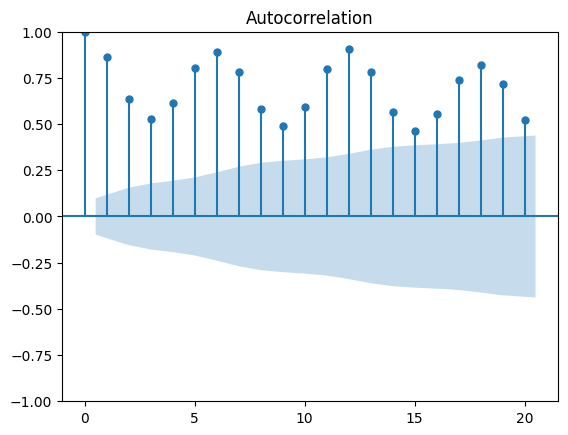

In [15]:
plot_acf(df, lags=20)
plt.show()

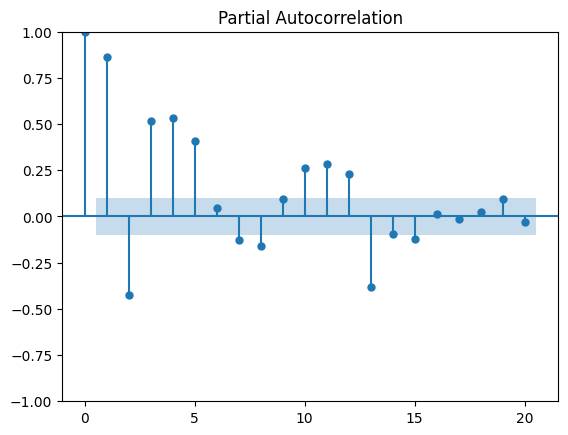

In [16]:
plot_pacf(df, lags=20)
plt.show()

In [17]:
def create_features(df, lags=4):
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df['Electricity'].shift(lag)
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df.dropna()

df = create_features(df)
df['rolling_mean_7'] = df['Electricity'].rolling(window=7).mean()
df['day'] = df.index.day
df['quarter'] = df.index.quarter
df.head()

C:\Users\Robyi\AppData\Local\Temp\ipykernel_18420\2083429826.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_mean_7'] = df['Electricity'].rolling(window=7).mean()
C:\Users\Robyi\AppData\Local\Temp\ipykernel_18420\2083429826.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
C:\Users\Robyi\AppData\Local\Temp\ipykernel_18420\2083429826.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,Electricity,lag_1,lag_2,lag_3,lag_4,month,year,rolling_mean_7,day,quarter
Date,,,,,,,,,,
1985-05-01,55.3151,57.4714,62.4502,70.6720,72.5052,5,1985,NaN,1,2
1985-06-01,58.0904,55.3151,57.4714,62.4502,70.6720,6,1985,NaN,1,2
1985-07-01,62.6202,58.0904,55.3151,57.4714,62.4502,7,1985,NaN,1,3
1985-08-01,63.2485,62.6202,58.0904,55.3151,57.4714,8,1985,NaN,1,3
1985-09-01,60.5846,63.2485,62.6202,58.0904,55.3151,9,1985,NaN,1,3


In [18]:
df['diff_1'] = df['Electricity'].diff(1)

C:\Users\Robyi\AppData\Local\Temp\ipykernel_18420\1951597253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_1'] = df['Electricity'].diff(1)


In [19]:
df = df.dropna()

In [20]:
X = df.drop('Electricity', axis=1)
y = df['Electricity']

In [21]:
train_size = int(0.8 * len(df))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [22]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('sgd', SGDRegressor(random_state=42))
])

In [23]:
param_grid = {
    'sgd__eta0': [0.001, 0.01, 0.1],
    'sgd__penalty': ['l1', 'l2', 'elasticnet'],
    'sgd__alpha': [0.0001, 0.001, 0.01],
    'sgd__learning_rate':[0.01,0.1,'adaptive','constant']
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params: {'sgd__alpha': 0.01, 'sgd__eta0': 0.1, 'sgd__learning_rate': 'adaptive', 'sgd__penalty': 'l1'}


C:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Robyi\App

In [25]:
def calculate_mase(y_true, y_pred, y_train):
    naive_forecast = y_train.shift(1).dropna()
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

In [26]:
metrics = {
    'MAE': [mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)],
    'RMSE': [np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))],
    'MAPE': [mean_absolute_percentage_error(y_train, y_pred_train), mean_absolute_percentage_error(y_test, y_pred_test)],
    'MASE': [calculate_mase(y_train, y_pred_train, y_train), calculate_mase(y_test, y_pred_test, y_train)]
}

metrics_df = pd.DataFrame(metrics, index=['Train', 'Test'])
print(metrics_df)

            MAE      RMSE      MAPE      MASE
Train  0.130442  0.163282  0.001523  0.020785
Test   0.161369  0.201748  0.001552  0.025713


In [27]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.named_steps['sgd'].coef_
}).sort_values('Coefficient', ascending=False)

feature_importance

,Feature,Coefficient
0,lag_1,61.184698
9,diff_1,36.048707
6,rolling_mean_7,2.335400
1,lag_2,0.000000
4,month,0.000000
5,year,0.000000
7,day,0.000000
8,quarter,0.000000
3,lag_4,-0.011373
2,lag_3,-0.802351


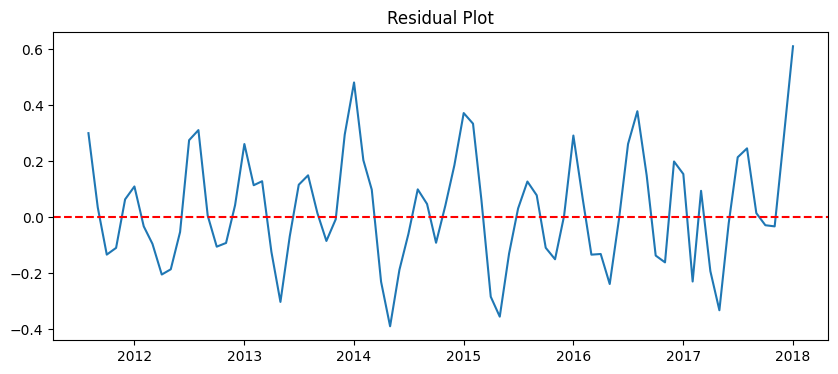

In [28]:
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

Prediksi produksi bulan depan: 128.79


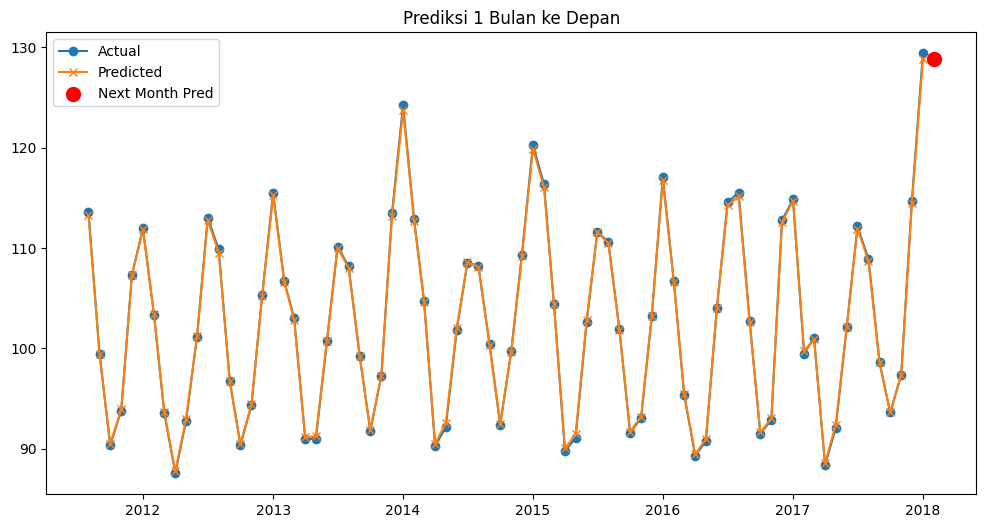

In [29]:
last_data = X.iloc[[-1]] 

next_month_pred = best_model.predict(last_data)
print(f"Prediksi produksi bulan depan: {next_month_pred[0]:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred_test, label='Predicted', marker='x')
plt.scatter(y_test.index[-1] + pd.DateOffset(months=1), next_month_pred, color='red', label='Next Month Pred', s=100)
plt.title("Prediksi 1 Bulan ke Depan")
plt.legend()
plt.show()